In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from belief_tree import Tree

### Initialise the agent

In [2]:
def policy(q_values, temp=None, policy_type='softmax'):

    '''
    ----
    Agent's policy

    q_values -- q values at the current state
    temp     -- inverse temperature
    type     -- softmax / greeedy
    ----
    '''

    if np.all(q_values == 0):
        return np.array([0.5, 0.5])

    if temp:
        t = temp
    else:
        t = 1
        
    if policy_type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    elif policy_type == 'greedy':
        return np.array(q_values >= q_values.max()).astype(int)
    else:
        raise KeyError('Unknown policy type')

In [ ]:
M = np.array([
    [29, 1],
    [1, 1]
])

gamma = 0.9
xi    = 0.0

Q = np.zeros(2)

tree = Tree(M, Q, 1, 'greedy')

### Full Bayesian updates

In [ ]:
horizon = 3
tree.root_q_values = Q
tree.build_tree(horizon)
tree.full_updates(gamma)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Replay

In [ ]:
horizon = 3
tree.root_q_values = Q
tree.build_tree(horizon)
qval_history, need_history, replays = tree.replay_updates(gamma, xi)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Generate replay tree

In [ ]:
from tex_tree import generate_big_tex_tree

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/example_tree/seq/'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)
else:
    os.makedirs(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_%u.tex'%idx)
    generate_big_tex_tree(horizon, these_replays, qval_history[idx], need_history[idx], save_path)

### Distribution updates asymmetry 

In [ ]:
from scipy.stats import beta
from scipy.special import kl_div

In [ ]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = np.array([2, 1])
rv1b = beta(a1b, b1b)  

a1a, b1a = np.array([3, 1])
rv1a = beta(a1a, b1a)

a1aa, b1aa = np.array([4, 1])
rv1aa = beta(a1aa, b1aa)

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(x, rv1b.pdf(x))
plt.title(r'$\alpha=2, \beta=1$')

plt.subplot(132)
plt.plot(x, rv1a.pdf(x))
plt.title(r'$\alpha=3, \beta=1$')

print(np.sum(kl_div(rv1b.pdf(x), rv1a.pdf(x))))

plt.subplot(133)
plt.plot(x, rv1aa.pdf(x))
plt.title(r'$\alpha=4, \beta=1$')

print(np.sum(kl_div(rv1a.pdf(x), rv1aa.pdf(x))))

plt.tight_layout()

# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')

### Number of replays until convergence

In [ ]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/data/convergence/num_replays/'

# vary these parameters
alphas_0 = np.arange(1, 40)
betas_0  = np.arange(1, 40)

# constant parameters
alpha_1 = 1
beta_1  = 1

gamma = 0.9
xi    = 0.0

for horizon in [2, 3, 4, 5]:

    # R = np.full((len(alphas_0), len(betas_0)), np.nan)

    # for alpha_0 in alphas_0:
    #     for beta_0 in betas_0:
            
    #         num_replays = 0

    #         # prior belie at the root
    #         M = np.array([
    #             [alpha_0, beta_0],
    #             [alpha_1, beta_1],
    #         ])

    #         # MF Q values at the root
    #         Q    = np.zeros(2)

    #         # initialise the agent
    #         tree = Tree(M, Q, 1, 'softmax')

    #         # build the tree
    #         tree.build_tree(horizon)
            
    #         # do full bayesian updates
    #         tree.full_updates(gamma)
    #         qval_tree = tree.qval_tree
    #         qvals     = qval_tree[0][(0, 0, 0)]
    #         print(r'$\alpha_0=%u, \beta_0=%u$'%(alpha_0, beta_0))
    #         v_full = np.max(qvals)
            
    #         # do replay
    #         tree.root_q_values = np.zeros(2)
    #         qval_history, need_history, replays = tree.replay_updates(gamma, xi)
    #         for qval_tree_idx in range(len(qval_history)):
    #             qval_tree = qval_history[qval_tree_idx]
    #             qvals     = qval_tree[0][(0, 0, 0)]
    #             v_replay  = np.max(qvals)
    #             if np.abs(v_replay - v_full) == 0: # converged after this many replays
    #                 R[alpha_0-alphas_0[0], beta_0-betas_0[0]] = qval_tree_idx
    #                 break
    
    file_name = 'horizon%u_alpha%u_beta%u'%(horizon, alpha_1, beta_1)
    R = np.load(os.path.join(save_folder, 'data', file_name + '.npy'))

    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    # plt.contourf(R, vmax=np.nanmax(R))
    plt.pcolormesh(R, vmax=np.nanmax(R))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of replays', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)

    file_name = 'horizon%u_alpha%u_beta%u'%(horizon, alpha_1, beta_1)
    # np.save(os.path.join(save_folder, 'data', file_name + '.npy'), R)
    plt.savefig(os.path.join(save_folder, file_name + '.png'))

    plt.close()

    print('Done with horizon %u'%horizon)

### Replay threshold and value convergence

Horizon 2
Horizon 3
Horizon 4
Horizon 5
Horizon 6


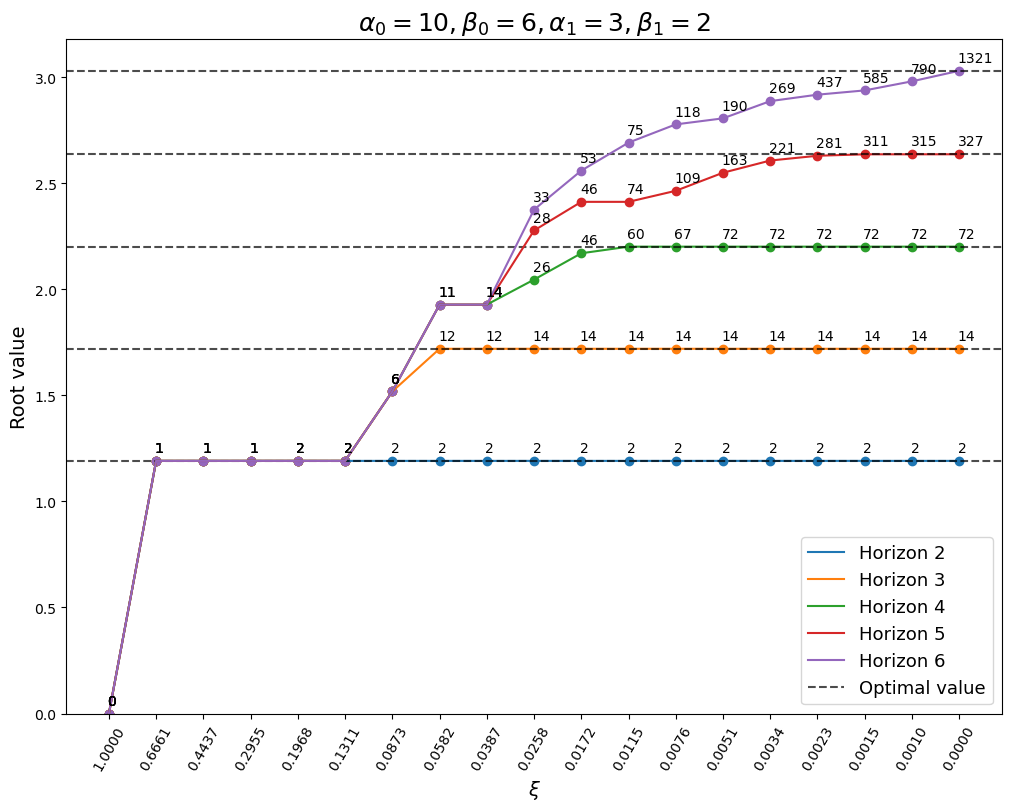

In [3]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/data/convergence/xi'

# vary these parameters
xis       = np.append(0, np.logspace(np.log2(0.001), np.log2(1.0), 18, base=2))
horizons  = [2, 3, 4, 5, 6]

# constant parameters
alpha_0 = 10
beta_0  = 6
alpha_1 = 3
beta_1  = 2

gamma   = 0.9

# prior belie at the root
M = np.array([
    [alpha_0, beta_0],
    [alpha_1, beta_1],
], dtype=int)

# MF Q values at the root
Q    = np.zeros(2)

# initialise the agent
tree = Tree(M, Q, 1, 'softmax')

# store results here
R      = np.zeros((len(horizons), len(xis)))
nreps  = np.zeros((len(horizons), len(xis)), dtype=int)
R_true = np.zeros(len(horizons))

for hidx, horizon in enumerate(horizons):
            
    num_replays = 0

    # build the tree
    tree.build_tree(horizon)
    
    # do full bayesian updates
    tree.full_updates(gamma)
    qval_tree = tree.qval_tree
    qvals     = qval_tree[0][(0, 0, 0)]
    v_full    = np.max(qvals)
    R_true[hidx] = v_full
    
    for xidx, xi in enumerate(xis):

        # do replay
        tree.root_q_values = np.zeros(2)
        qval_history, need_history, replays = tree.replay_updates(gamma, xi)
        qval_tree = tree.qval_tree
        qvals     = qval_tree[0][(0, 0, 0)]
        v_replay  = np.max(qvals)
        R[hidx, xidx]     = v_replay
        nreps[hidx, xidx] = len(replays)-1

    print('Horizon %u'%horizon)
    
fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
for hi in range(len(horizons)):
    plt.plot(R[hi, ::-1], label='Horizon %u'%(hi+2))
    plt.scatter(range(len(xis)), R[hi, ::-1])
    for x in range(len(xis)):
        plt.text(x-0.03, R[hi, len(xis)-x-1]+0.04, nreps[hi, len(xis)-x-1])
    if hi == (len(horizons)-1):
        plt.axhline(R_true[hi], linestyle='--', color='k', alpha=0.7, label='Optimal value')
    else:
        plt.axhline(R_true[hi], linestyle='--', alpha=0.7, color='k')

plt.xlabel(r'$\xi$', fontsize=14)
plt.xticks(range(R.shape[1]), ['%.4f'%i for i in xis[::-1]], rotation=60)
plt.ylabel('Root value', fontsize=14)
plt.ylim(0,)
plt.title(r'$\alpha_0=%u, \beta_0=%u, \alpha_1=%u, \beta_1=%u$'%(alpha_0, beta_0, alpha_1, beta_1), fontsize=18)
plt.legend(prop={'size': 13})

file_name = 'alpha0%u_beta0%u_alpha1%u_beta1%u'%(alpha_0, beta_0, alpha_1, beta_1)
np.save(os.path.join(save_folder, 'data', file_name + '.npy'), R)
plt.savefig(os.path.join(save_folder, file_name + '.png'))

# plt.close()



In [35]:
5/9

0.5555555555555556